In [226]:
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

sys.path.append(str(Path.cwd().parent / 'scripts'))
from _helpers import classify_north_south

idx = pd.IndexSlice

In [227]:
day = '2022-01-03'

In [181]:
# rev_path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_flex_{}.csv')
rev_path = str(Path.cwd().parent / 'results' / f'{day}' / 'bmu_revenues_flex_{}.csv')

rev_national = pd.read_csv(rev_path.format('national'), index_col=0, header=[0,1,2], parse_dates=True).sum().mul(1e-6)
rev_zonal = pd.read_csv(rev_path.format('zonal'), index_col=0, header=[0,1,2], parse_dates=True).sum().mul(1e-6)

In [182]:
rev_national = pd.concat((
    rev_national.loc[idx[:, ['wind', 'disp', 'hydro', 'storage'], :]],
    pd.Series(rev_national.loc[idx[:, 'intercon', :]].sum(), index=pd.MultiIndex.from_tuples([('total', 'interconnector', 'wholesale')]))
))

rev_zonal = pd.concat((
    rev_zonal.loc[idx[:, ['wind', 'disp', 'hydro', 'storage'], :]],
    pd.Series(rev_zonal.loc[idx[:, 'intercon', :]].sum(), index=pd.MultiIndex.from_tuples([('total', 'interconnector', 'wholesale')]))
))

In [183]:
cost_summary = pd.read_csv(
    Path.cwd().parent / 'results' / f'{day}' / 'system_cost_summary_flex.csv', 
    index_col=[0,1],
    parse_dates=[0]
    )

cost_summary.head()

nodal     zonal  national
snapshot                                                
2022-01-03 wholesale        1.220878  1.223936  0.878185
           congestion_rent -0.458879 -0.459534  0.000000
           cfd_payments     0.027035  0.026803  0.085186
           roc_payments     0.618494  0.618494  0.617619
           offer_cost       0.000000  0.000000  0.274134

In [184]:
mp = pd.read_csv(
    Path.cwd().parent / 'results' / f'{day}' / 'marginal_prices_flex.csv',
    index_col=0,
    parse_dates=[0],
    header=[0,1]
    )

In [185]:
idx = pd.IndexSlice

buses = mp.loc[:,idx['zonal',:]].columns.get_level_values(1)

In [186]:
weights = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv', index_col=0)

weights = weights.loc[buses.astype(int)]
weights /= weights.sum()

In [187]:
load = pd.read_csv(
    Path.cwd().parent / 'results' / f'{day}' / 'gb_total_load_flex.csv',
    index_col=0,
    parse_dates=[0]
).rename(columns={'0': 'load'})

load = pd.DataFrame(
    np.outer(load.values, weights.values),
    index=load.index,
    columns=weights.index.astype(str)
    )

load.head()

Bus,8838,8013,8649,4950,4951,4952,4953,4955,4956,4958,...,8021,8578,7469,8027,8016,8019,7458,8283,8093,7908
snapshot,,,,,,,,,,,,,,,,,,,,,
2022-01-03 00:00:00,79.193985,8.034199,124.598465,98.250006,88.983703,88.371027,87.129910,78.044076,134.435813,65.720927,...,113.990376,133.563050,15.310423,69.290279,89.309383,2.394011,43.735515,170.964211,124.501395,93.002743
2022-01-03 00:30:00,79.466697,8.061866,125.027531,98.588339,89.290126,88.675340,87.429950,78.312827,134.898754,65.947243,...,114.382912,134.022985,15.363146,69.528886,89.616927,2.402255,43.886122,171.552941,124.930126,93.323006
2022-01-03 01:00:00,81.588464,8.277118,128.365776,101.220656,91.674180,91.042980,89.764337,80.403786,138.500562,67.708040,...,117.436945,137.601410,15.773343,71.385313,92.009707,2.466395,45.057885,176.133419,128.265771,95.814739
2022-01-03 01:30:00,80.921377,8.209443,127.316227,100.393051,90.924630,90.298590,89.030402,79.746386,137.368148,67.154443,...,116.476752,136.476348,15.644376,70.801649,91.257413,2.446230,44.689481,174.693310,127.217039,95.031334
2022-01-03 02:00:00,79.139575,8.028679,124.512860,98.182504,88.922567,88.310312,87.070048,77.990456,134.343449,65.675774,...,113.912059,133.471285,15.299904,69.242673,89.248023,2.392366,43.705466,170.846751,124.415857,92.938846


In [188]:
network = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_nodal.nc'
)
buses = network.buses[['x', 'y']]
buses.loc[:, ['region']] = buses.apply(lambda x: classify_north_south(x['x'], x['y']), axis=1)

INFO:pypsa.io:Imported network network_flex_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


In [189]:
north_loads = load.loc[:, buses.loc[buses.region == 'north'].index]
south_loads = load.loc[:, buses.loc[buses.region == 'south'].index.intersection(load.columns)]

print(north_loads.shape)
print(south_loads.shape)

(48, 60)
(48, 224)


In [190]:
import warnings
warnings.filterwarnings('ignore')

def get_wholesale_costs(mp, loads, mode):

    idx = pd.IndexSlice

    if mode == 'national':
        return np.inner(
            loads.sum(axis=1).values,
            mp.loc[:,idx['national', 'GB']].values
            ) * 0.5
        
    elif mode == 'zonal':
        total = 0
        for col in loads.columns:
            total += np.inner(
                loads.loc[:,col].values,
                mp.loc[:,idx['zonal', col]].values
                )
        return total * 0.5


costs = pd.Series(0, # is in units M£
    index=pd.MultiIndex.from_product([
        ['wholesale'],
        ['north', 'south'],
        ['national', 'zonal']
        ]
    ).append(
        pd.MultiIndex.from_product([
            ['roc', 'cfd', 'bids', 'offers', 'cfd'],
            ['socialised'],
            ['national', 'zonal']
            ]
        )
    )
)

costs.loc[idx['wholesale', 'north', 'national']] = get_wholesale_costs(mp, north_loads, 'national') * 1e-6
costs.loc[idx['wholesale', 'south', 'national']] = get_wholesale_costs(mp, south_loads, 'national') * 1e-6
costs.loc[idx['wholesale', 'north', 'zonal']] = get_wholesale_costs(mp, north_loads, 'zonal') * 1e-6
costs.loc[idx['wholesale', 'south', 'zonal']] = get_wholesale_costs(mp, south_loads, 'zonal') * 1e-6

costs.loc[idx['roc', 'socialised', 'national']] = cost_summary.loc[idx[:, 'roc_payments'], 'national'].sum()
costs.loc[idx['cfd', 'socialised', 'national']] = cost_summary.loc[idx[:, 'cfd_payments'], 'national'].sum()
costs.loc[idx['bids', 'socialised', 'national']] = cost_summary.loc[idx[:, 'bid_cost'], 'national'].sum()
costs.loc[idx['offers', 'socialised', 'national']] = cost_summary.loc[idx[:, 'offer_cost'], 'national'].sum()
costs.loc[idx['cfd', 'socialised', 'national']] = cost_summary.loc[idx[:, 'cfd_payments'], 'national'].sum()

costs.loc[idx['roc', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'roc_payments'], 'zonal'].sum()
costs.loc[idx['cfd', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'cfd_payments'], 'zonal'].sum()
costs.loc[idx['bids', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'bid_cost'], 'zonal'].sum()
costs.loc[idx['offers', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'offer_cost'], 'zonal'].sum()
costs.loc[idx['cfd', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'cfd_payments'], 'zonal'].sum()

costs

wholesale  north       national     2.529330
                       zonal       -0.235061
           south       national    74.451359
                       zonal       80.839466
roc        socialised  national    24.013230
                       zonal       24.095351
cfd        socialised  national     3.646681
                       zonal        3.866182
bids       socialised  national     1.946248
                       zonal       -0.002634
offers     socialised  national     7.415200
                       zonal        0.058493
cfd        socialised  national     3.646681
                       zonal        3.866182
dtype: float64

In [191]:
def get_consumer_box_limits(costs, mode, gap):

    box1 = costs.loc[idx['wholesale', 'north', mode]].sum()
    box2 = costs.loc[idx['wholesale', 'south', mode]].sum()
    box3 = costs.loc[idx[:, 'socialised', mode]].sum()

    total = box1 + box2 + box3

    box1 = box1 / total
    box2 = box2 / total
    box3 = box3 / total

    box1_upper = 1
    box1_lower = box1_upper - box1

    box2_upper = box1_lower - gap
    box2_lower = box2_upper - box2

    box3_upper = box2_lower - gap
    box3_lower = box3_upper - box3

    return (
        (box1_upper, box1_lower),
        (box2_upper, box2_lower),
        (box3_upper, box3_lower)
    )


gap = 0.02
box_width = 0.03
left_end = 0.
right_end = 1.




In [192]:
# rev_national = rev_national.sort_index()


In [193]:
def get_generator_box_limits(revs, gap):

    box_heights = {}

    revs = revs.copy() / revs.sum()

    for region, carrier in zip(revs.index.get_level_values(0), revs.index.get_level_values(1)):

        box_heights[(region, carrier)] = revs.loc[idx[region, carrier, :]].sum()

    box_upper = {}
    box_lower = {}

    # Sort by region first, then carrier
    sorted_items = sorted(box_heights.keys(), key=lambda x: (x[0], x[1]))

    current_upper = 1
    for item in sorted_items:
        box_upper[item] = current_upper
        box_lower[item] = current_upper - box_heights[item]
        current_upper = box_lower[item] - gap

    # Handle interconnector separately since it's in 'total' region
    box_upper[('total', 'interconnector')] = current_upper
    box_lower[('total', 'interconnector')] = current_upper - box_heights[('total', 'interconnector')]

    return box_lower, box_upper


In [196]:
# Helper function to draw curved flow paths
def bezier_path(start, end, turning_ratio, num_samples=100):
    """
    Creates a smooth cubic Bézier curve as a NumPy array of points,
    suitable for use in Sankey diagrams.

    Parameters:
        start (tuple or list): (x, y) coordinates for the starting point.
        end (tuple or list): (x, y) coordinates for the ending point.
        turning_ratio (float): A value between 0 and 1 that defines the x-position
                               of the turning point. A value of 0 means the turning
                               point is at the start's x-coordinate, while 1 is at the end's.
        num_samples (int): The number of points to sample along the curve.

    Returns:
        numpy.ndarray: An array of shape (num_samples, 2) with the (x, y) coordinates of the curve.
    """
    # Convert start and end to NumPy arrays
    start = np.array(start, dtype=float)
    end = np.array(end, dtype=float)
    
    # Compute the common x-coordinate for both control points based on turning_ratio
    cp_x = start[0] + turning_ratio * (end[0] - start[0])
    
    # Define control points
    cp1 = np.array([cp_x, start[1]])
    cp2 = np.array([cp_x, end[1]])
    
    # Create an array of parameter values t in [0, 1]
    t = np.linspace(0, 1, num_samples).reshape(-1, 1)  # shape (num_samples, 1)
    one_minus_t = 1 - t

    # Evaluate the cubic Bézier curve at each t using the formula:
    # B(t) = (1-t)^3 * P0 + 3*(1-t)^2*t * P1 + 3*(1-t)*t^2 * P2 + t^3 * P3
    curve = (one_minus_t**3) * start + \
            3 * (one_minus_t**2) * t * cp1 + \
            3 * one_minus_t * (t**2) * cp2 + \
            (t**3) * end

    return curve[:,0], curve[:,1]

In [200]:
class FlowStart:

    def __init__(self, upper_bound, lower_bound):
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.current_upper = upper_bound

    def __str__(self):
        return f"FlowStart(upper_bound={self.upper_bound:.4f}, lower_bound={self.lower_bound:.4f}, current_upper={self.current_upper:.4f})"

    def add_flow(self, flow):
        return_value = self.current_upper
        self.current_upper -= flow
        return return_value
    
    def __repr__(self):
        return self.__str__()
    

In [232]:
def reset_flowstarts(rev_lowers, rev_uppers):
    flowstarts = {}

    for block_name in ['con_n', 'con_s', 'soc']:
        block = globals()[block_name]
        flowstarts[block_name] = FlowStart(
            *block
            )

    for (name, upper), (name2, lower) in zip(rev_uppers.items(), rev_lowers.items()):
        assert name == name2
        flowstarts[name] = FlowStart(
            upper,
            lower
            )
    
    return flowstarts

In [230]:
def prepare_plot_data(mode):

    con_n, con_s, soc = get_consumer_box_limits(costs, mode, gap)

    rev = globals()[f'rev_{mode}']
    rev = rev.sort_index()

    rev_lowers, rev_uppers = get_generator_box_limits(rev, gap)
    rev_flows = rev.copy() / rev.sum()

    return con_n, con_s, soc, rev_lowers, rev_uppers, rev_flows

In [203]:
color_mapper = {
    'roc': color_dict['roc_payments'],
    'cfd': color_dict['cfd_payments'],
    'bids': color_dict['bid_cost'],
    'offers': color_dict['offer_cost'],
    'wholesale': color_dict['wholesale'],
    'congestion_rents': color_dict['congestion_rent']
}

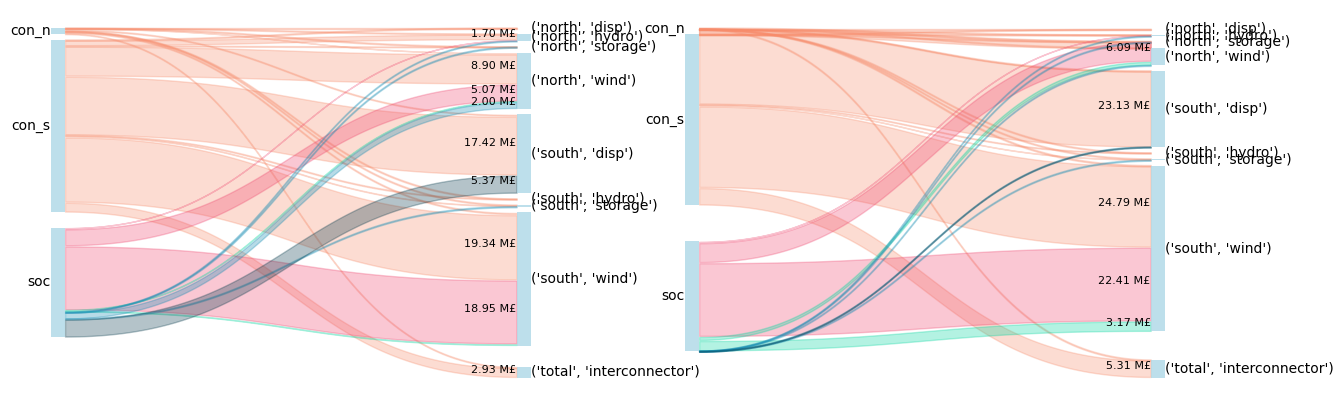

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# def add_flow(ax, left_upper, right_upper, box_width, volume, tp=0.5):
def add_flow(
        ax,
        left_upper,
        right_upper,
        flow_vol,
        tp=0.5,
        color='r',
        text_threshold=0.02):

    start = (box_width, left_upper - flow_vol/2)
    end = (1-box_width, right_upper - flow_vol/2)

    x, y = bezier_path(start, end, tp)

    prevent_overlap = 0.002
    ax.fill_between(x, y-flow_vol/2 + prevent_overlap, y+flow_vol/2 - prevent_overlap, alpha=0.3, color=color)

    if flow_vol > text_threshold:
        ax.text(
            x[-1],
            y[-1],
            f'{flow_vol*rev_national.sum():.2f} M£',
            ha='right',
            fontsize=8
            )

for mode, ax in zip(['national', 'zonal'], axs):

    con_n, con_s, soc, rev_lowers, rev_uppers, rev_flows = prepare_plot_data(mode)

    weight_north = (con_n[0] - con_n[1]) / (con_n[0] - con_n[1] + con_s[0] - con_s[1])
    weight_south = (con_s[0] - con_s[1]) / (con_n[0] - con_n[1] + con_s[0] - con_s[1])

    flowstarts = reset_flowstarts(rev_lowers, rev_uppers)

    for (region, carrier), flow in rev_flows.loc[idx[:, :, 'wholesale']].items():
        north_flow = flow * weight_north
        south_flow = flow * weight_south

        add_flow(
            ax,
            flowstarts['con_n'].add_flow(north_flow),
            flowstarts[(region, carrier)].add_flow(north_flow),
            north_flow,
            color=color_mapper['wholesale']
            )

        add_flow(
            ax,
            flowstarts['con_s'].add_flow(south_flow),
            flowstarts[(region, carrier)].add_flow(south_flow),
            south_flow,
            color=color_mapper['wholesale']
            )

    for factor, tp in zip(['roc', 'cfd', 'bids', 'offers'], [0.5, 0.5, 0.5, 0.5]):


        for (region, carrier), flow in rev_flows.loc[idx[:, :, factor]].items():

            if flow == 0:
                continue

            add_flow(
                ax,
                flowstarts['soc'].add_flow(flow),
                flowstarts[(region, carrier)].add_flow(flow),
                flow,
                color=color_mapper[factor],
                tp=tp
                )

    for cost_party in ['con_n', 'con_s', 'soc']:

        ax.add_patch(plt.Rectangle((
            left_end,
            flowstarts[cost_party].current_upper),
            box_width,
            flowstarts[cost_party].upper_bound - flowstarts[cost_party].current_upper,
            facecolor='lightblue',
            alpha=0.8
            ))
        ax.text(
            0,
            flowstarts[cost_party].current_upper + (flowstarts[cost_party].upper_bound - flowstarts[cost_party].current_upper)/2,
            cost_party,
            ha='right',
            va='center'
            )

    for lower, upper, name in zip(rev_lowers.values(), rev_uppers.values(), rev_lowers.keys()):

        min_height = 0.002
        height = max(upper-lower, min_height)

        ax.add_patch(plt.Rectangle((right_end - box_width, lower), box_width, height, facecolor='lightblue', alpha=0.8))

        ax.text(
            right_end,
            lower + (upper-lower)/2,
            name,
            ha='left',
            va='center'
            )

    ax.axis('off')

plt.savefig('money_flow.pdf')
plt.show()

In [225]:
rev_zonal

north  wind            wholesale   -1.691357e+00
                       offers       0.000000e+00
                       bids         2.501404e-02
                       cfd          1.032431e+00
                       roc          5.147254e+00
south  wind            wholesale    2.089771e+01
                       offers       0.000000e+00
                       bids         0.000000e+00
                       cfd          2.679384e+00
                       roc          1.894810e+01
north  disp            wholesale    0.000000e+00
                       offers       0.000000e+00
                       bids         0.000000e+00
                       cfd          0.000000e+00
                       roc          0.000000e+00
south  disp            wholesale    1.949517e+01
                       offers       8.006606e-02
                       bids        -3.048812e-14
                       cfd          0.000000e+00
                       roc          0.000000e+00
north  hydro        

In [147]:
rev_flows

north  disp            bids        -6.673064e-05
                       cfd          0.000000e+00
                       offers       1.998749e-13
                       roc          0.000000e+00
                       wholesale    3.891764e-02
       hydro           bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          3.726007e-03
                       wholesale    8.095866e-03
       storage         bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          0.000000e+00
                       wholesale    1.472167e-03
       wind            bids         0.000000e+00
                       cfd          1.191479e-04
                       offers       0.000000e+00
                       roc          8.637755e-03
                       wholesale    9.775753e-03
south  disp         

In [136]:
color_dict

{'wholesale': '#F78C6B',
 'wholesale selling': '#F78C6B',
 'wholesale buying': '#c3763c',
 'roc_payments': '#EF476F',
 'cfd_payments': '#06D6A0',
 'congestion_rent': '#FFD166',
 'offer_cost': '#073B4C',
 'bid_cost': '#118AB2'}

In [139]:
rev_zonal

north  wind            wholesale    4.323307e-01
                       offers       0.000000e+00
                       bids         0.000000e+00
                       cfd          5.269291e-03
                       roc          3.820029e-01
south  wind            wholesale    6.718664e+00
                       offers       0.000000e+00
                       bids         0.000000e+00
                       cfd          2.458216e+00
                       roc          8.149639e+00
north  disp            wholesale    1.721125e+00
                       offers       3.358307e-13
                       bids        -2.951149e-03
                       cfd          0.000000e+00
                       roc          0.000000e+00
south  disp            wholesale    1.809570e+01
                       offers       1.457364e-02
                       bids        -8.700657e-14
                       cfd          0.000000e+00
                       roc          0.000000e+00
north  hydro        

In [95]:
for _ in range(10):
    flowstarts['soc'].add_flow(0.1)
    print(flowstarts['soc'])

FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.0950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.1950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.2950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.3950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.4950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.5950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.6950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.7950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.8950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.9950)


In [61]:
rev_national.sort_index(level=0)

north  disp            bids        -2.951149e-03
                       cfd          0.000000e+00
                       offers       8.839429e-12
                       roc          0.000000e+00
                       wholesale    1.721125e+00
       hydro           bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          1.647819e-01
                       wholesale    3.580380e-01
       storage         bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          0.000000e+00
                       wholesale    6.510627e-02
       wind            bids         0.000000e+00
                       cfd          5.269291e-03
                       offers       0.000000e+00
                       roc          3.820029e-01
                       wholesale    4.323307e-01
south  disp         

In [166]:
rev_uppers

{('north', 'wind'): 1,
 ('north', 'disp'): 0.6373634114479054,
 ('north', 'hydro'): 0.616861272342654,
 ('north', 'storage'): 0.5858894748202965,
 ('south', 'wind'): 0.5647625529746111,
 ('south', 'disp'): 0.1618262638915575,
 ('south', 'hydro'): -0.08766582736524565,
 ('south', 'storage'): -0.10787788701136596,
 ('total', 'interconnector'): -0.13217607451181007}

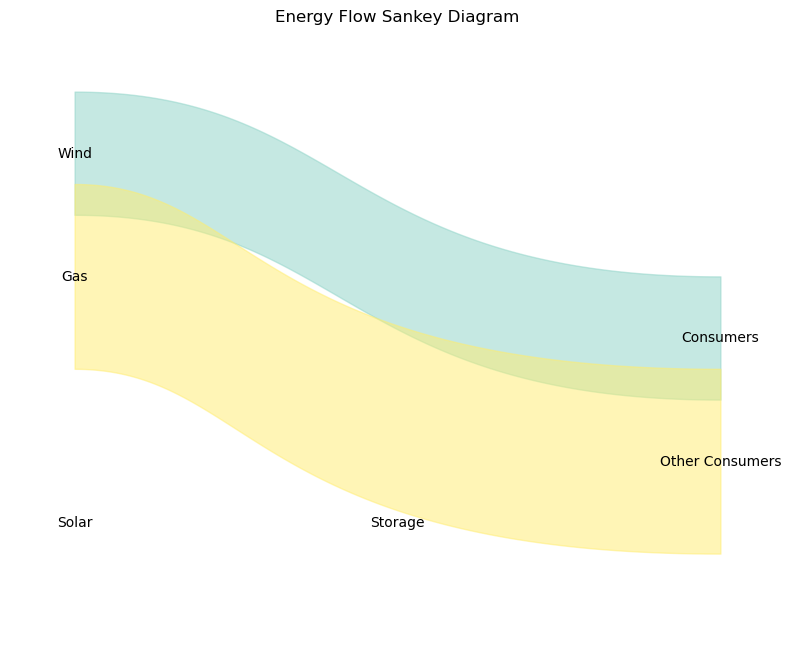

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create example Sankey data
nodes = ['Wind', 'Gas', 'Solar', 'Consumers', 'Storage']
flows = [
    ('Wind', 'Consumers', 0.2),
    ('Gas', 'Other Consumers', 0.3),
    # ('Solar', 'Storage', 20),
    # ('Storage', 'Consumers', 15),
]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Set node positions
node_pos = {
    'Wind': (0, 0.8),
    'Gas': (0, 0.6), 
    'Solar': (0, 0.2),
    'Storage': (0.5, 0.2),
    'Consumers': (1, 0.5),
    'Other Consumers': (1, 0.3)
}

# Draw flows
colors = plt.cm.Set3(np.linspace(0, 1, len(flows)))

for (source, target, value), color in zip(flows, colors):

    r = np.random.rand() * 0.5
    x, y = bezier_path(node_pos[source], node_pos[target], r)

    ax.fill_between(x, y-value/2, y+value/2, alpha=0.5, color=color)

# Draw nodes
for node, (x, y) in node_pos.items():
    ax.text(x, y, node, ha='center', va='center')

# Configure plot
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Energy Flow Sankey Diagram')

# plt.savefig('dummy_sankey.pdfk')
plt.show()

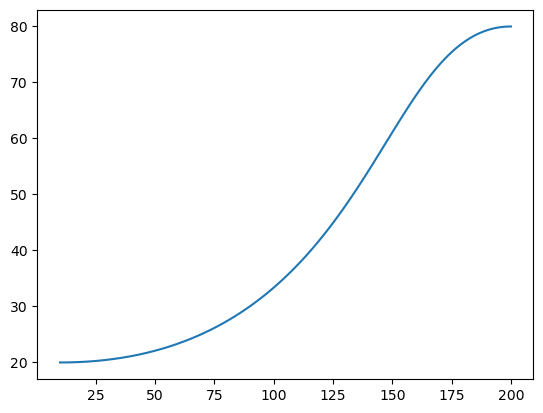

In [142]:
import numpy as np


# Example usage:
if __name__ == "__main__":
    start_point = (10, 20)
    end_point = (200, 80)
    turning_ratio = 0.7  # symmetric turning point along the x-axis
    bezier_points = create_bezier_curve(start_point, end_point, turning_ratio, num_samples=100)
    

    x = bezier_points[:,0]
    y = bezier_points[:,1]

    plt.plot(x, y)